In [7]:
# Install required packages
%pip install grad-cam

# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image

# Note: If grad-cam doesn't work, you may need to implement GradCAM manually
# or try alternative visualization methods like occlusion sensitivity



Note: you may need to restart the kernel to use updated packages.


In [8]:
import torch
import torch.nn as nn
from torchvision import models

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model architecture
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 1)  # Binary classification
)

# Load your trained weights
model.load_state_dict(torch.load("pneumonia_resnet_model_epoch_1.pth", map_location=device))

# Final setup
model = model.to(device)
model.eval()

print("Model loaded and ready.")

Model loaded and ready.


In [9]:
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import os

def pad_to_square(image):
    """Pad the image to make it square with zeros around the border."""
    w, h = image.size
    max_dim = max(w, h)
    pad_w = (max_dim - w) // 2
    pad_h = (max_dim - h) // 2
    padding = (pad_w, pad_h, max_dim - w - pad_w, max_dim - h - pad_h)
    return transforms.functional.pad(image, padding, fill=0)

# Custom dataset class for chest X-ray images
class ChestXRayDataset(Dataset):
    def __init__(self, root_dir, class_dirs, transform=None):
        self.filepaths = []
        self.labels = []
        self.transform = transform
        
        # Define label mapping dictionary
        self.label_map = {'NORMAL': 0, 'PNEUMONIA': 1}
        
        # For each class directory, collect all image paths and assign labels
        for class_dir in class_dirs:
            class_path = os.path.join(root_dir, class_dir)
            files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith(('.jpeg', '.jpg', '.png'))]
            self.filepaths.extend(files)
            self.labels.extend([self.label_map[class_dir]] * len(files))
        
    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        image = Image.open(img_path)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label, dtype=torch.long)

# Define paths for datasets
data_dir = 'data'  # Adjust this to your data directory
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Class directories
class_dirs = ['NORMAL', 'PNEUMONIA']

# Define mean and std values from the training set
mean = [0.34463736414909363, 0.34463736414909363, 0.34463736414909363]
std = [0.28305476903915405, 0.28305476903915405, 0.28305476903915405]

# Define the transform with normalization
transform = transforms.Compose([
    transforms.Lambda(pad_to_square),               # Pad to square
    transforms.Resize((224, 224)),                  # Resize to 224x224
    transforms.Grayscale(num_output_channels=3),    # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)        # Use training set normalization
])

# Create datasets with the transform
test_dataset = ChestXRayDataset(
    root_dir=test_dir,
    class_dirs=class_dirs,
    transform=transform
)

# Create data loader
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=32,
    shuffle=False
)

print(f"Test dataset size: {len(test_dataset)}")



Test dataset size: 624


In [10]:
# Collect 5 NORMAL and 5 PNEUMONIA images
normal_samples = []
pneumonia_samples = []
normal_indices = []
pneumonia_indices = []

for idx, (img, label) in enumerate(test_dataset):
    if label.item() == 0 and len(normal_samples) < 5:
        normal_samples.append((img, label))
        normal_indices.append(idx)
    elif label.item() == 1 and len(pneumonia_samples) < 5:
        pneumonia_samples.append((img, label))
        pneumonia_indices.append(idx)
    if len(normal_samples) == 5 and len(pneumonia_samples) == 5:
        break

selected_samples = normal_samples + pneumonia_samples
selected_indices = normal_indices + pneumonia_indices
print(f"Selected {len(selected_samples)} samples (5 normal + 5 pneumonia).")
print(f"Normal indices: {normal_indices}")
print(f"Pneumonia indices: {pneumonia_indices}")

Selected 10 samples (5 normal + 5 pneumonia).
Normal indices: [0, 1, 2, 3, 4]
Pneumonia indices: [234, 235, 236, 237, 238]


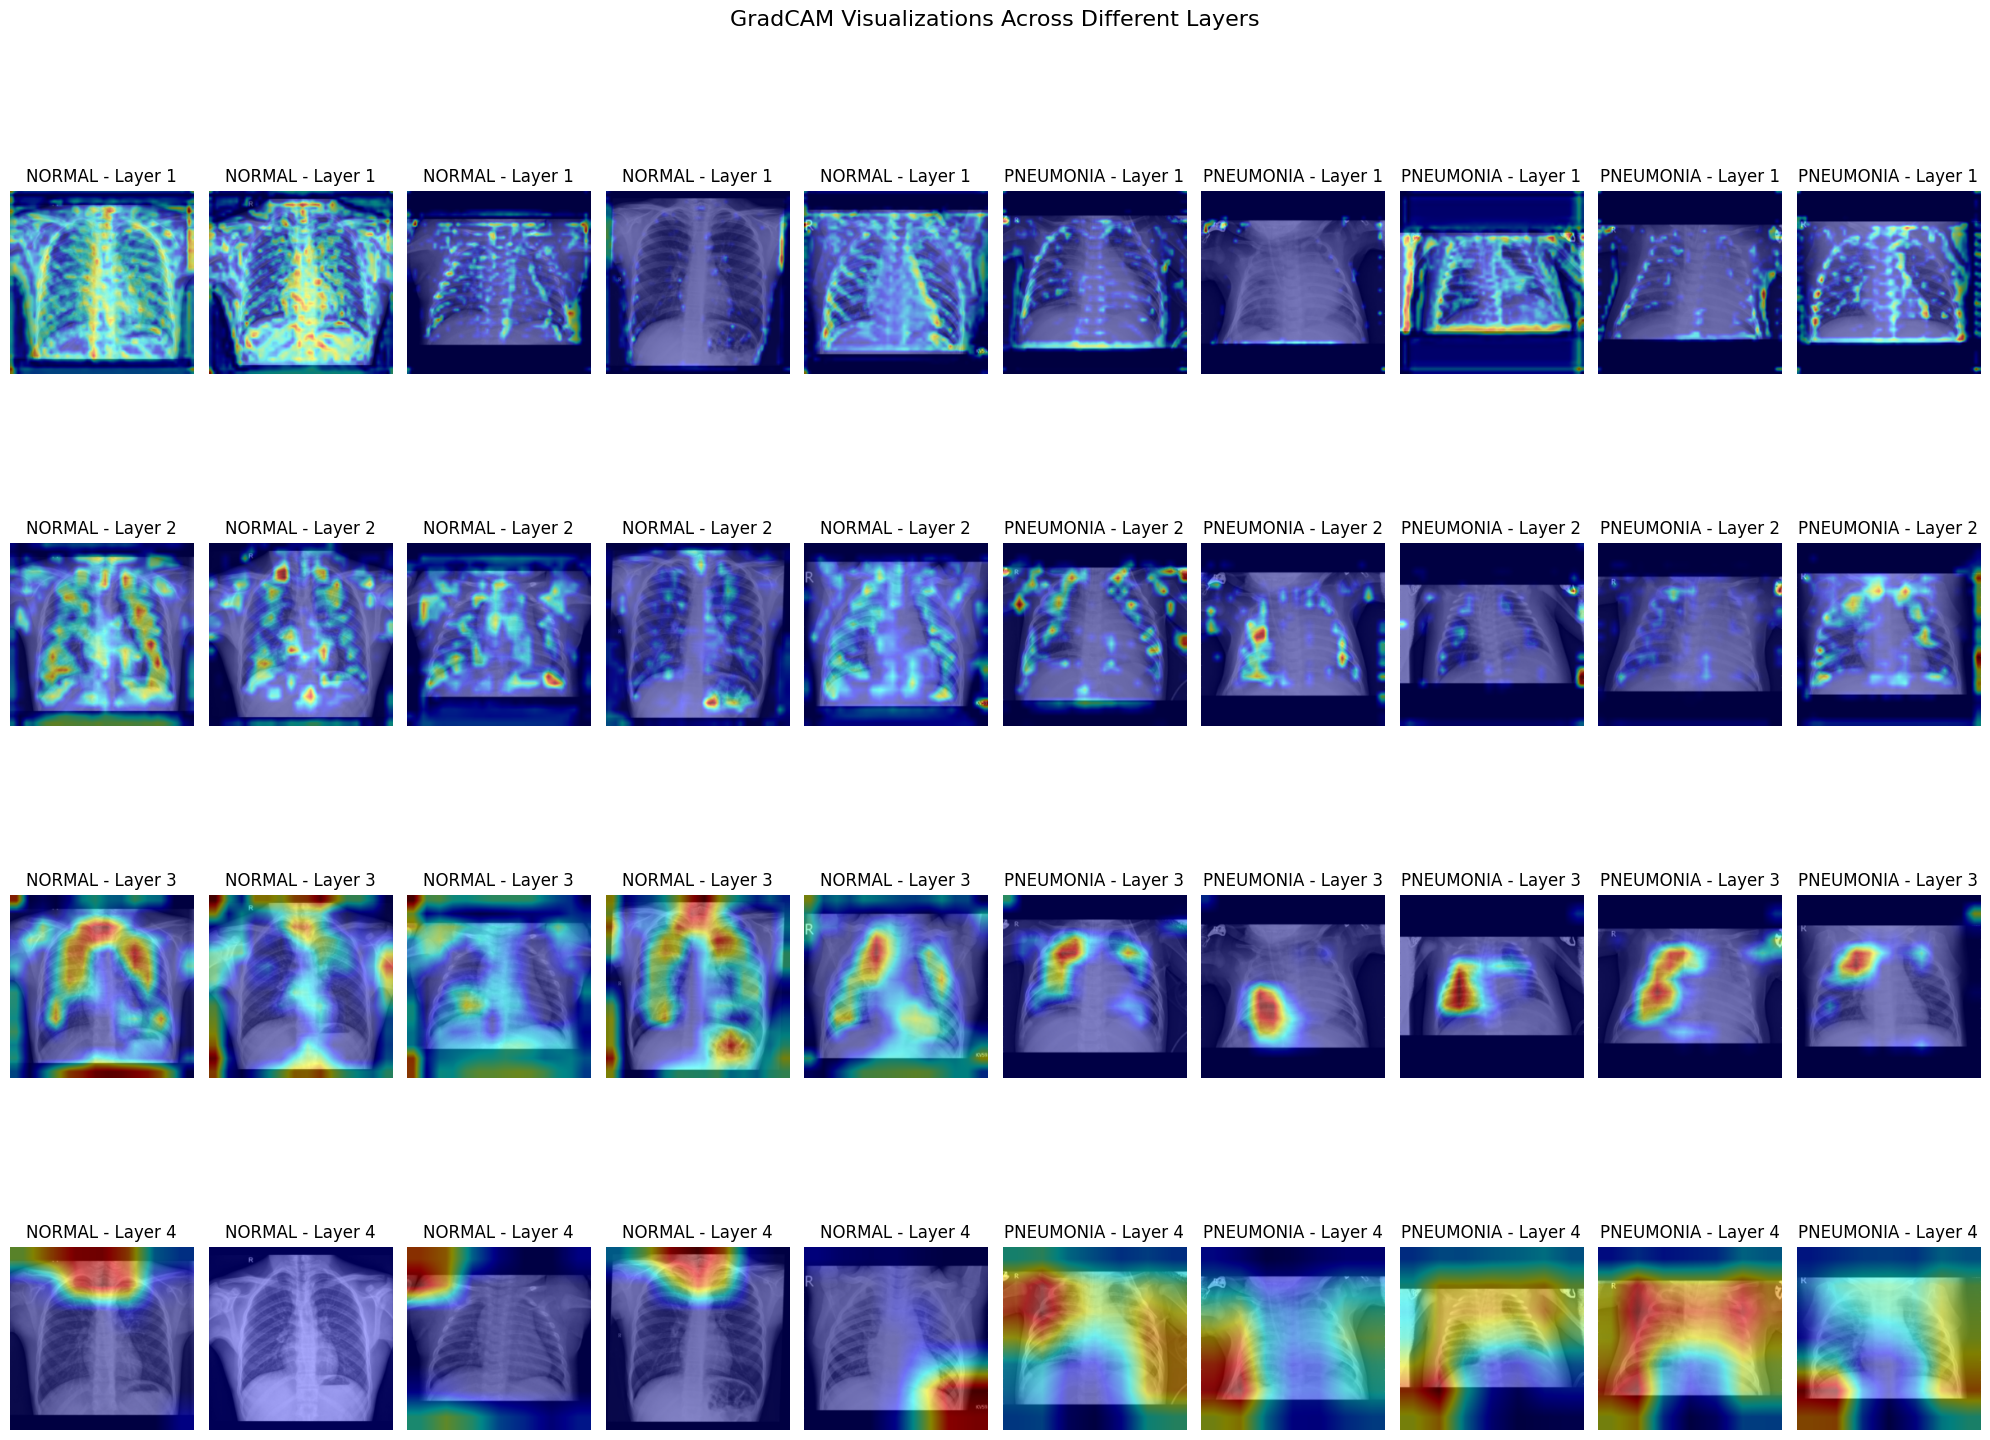

In [11]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import numpy as np


# Define different target layers for GradCAM to compare visualizations
# We'll try different layers from the ResNet18 architecture
target_layers = [
    model.layer1[-1],  # Early layer - captures basic features
    model.layer2[-1],  # Mid-level layer - captures intermediate features
    model.layer3[-1],  # Higher-level layer - captures more complex features
    model.layer4[-1]   # Final convolutional layer - captures highest-level features
]

# Function to apply GradCAM to an image with a specific target layer
def apply_gradcam(img_tensor, target_layer, target_class=None):
    # If target_class is None, use the predicted class
    if target_class is None:
        # Get model prediction
        with torch.no_grad():
            outputs = model(img_tensor.unsqueeze(0))
            target_class = outputs.argmax().item()
    
    # Create target for GradCAM
    targets = [ClassifierOutputTarget(target_class)]
    
    # Convert tensor to numpy for visualization
    img_np = img_tensor.cpu().numpy().transpose(1, 2, 0)
    # Normalize image for visualization
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    
    # Apply GradCAM with the specific target layer
    with GradCAM(model=model, target_layers=[target_layer]) as cam:
        grayscale_cam = cam(input_tensor=img_tensor.unsqueeze(0), targets=targets)
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
        
    return visualization, target_class

# Create a figure to display GradCAM visualizations for all layers
fig, axes = plt.subplots(len(target_layers), 10, figsize=(20, 4*len(target_layers)))
fig.suptitle('GradCAM Visualizations Across Different Layers', fontsize=16)

# Layer names for the plot titles
layer_names = ['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4']

# Loop through each layer
for layer_idx, target_layer in enumerate(target_layers):
    # Process NORMAL samples (first 5 columns)
    for i, (img, _) in enumerate(normal_samples):
        vis, pred_class = apply_gradcam(img, target_layer)
        axes[layer_idx, i].imshow(vis)
        axes[layer_idx, i].set_title(f"NORMAL - {layer_names[layer_idx]}")
        axes[layer_idx, i].axis('off')

    # Process PNEUMONIA samples (last 5 columns)
    for i, (img, _) in enumerate(pneumonia_samples):
        vis, pred_class = apply_gradcam(img, target_layer)
        axes[layer_idx, i+5].imshow(vis)
        axes[layer_idx, i+5].set_title(f"PNEUMONIA - {layer_names[layer_idx]}")
        axes[layer_idx, i+5].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()